,BB Temp
0,54.999802
1,50.001659
2,45.000671
3,39.999607
4,34.998707
5,30.000061
6,24.999840
7,20.001617
8,14.999565
9,9.999710


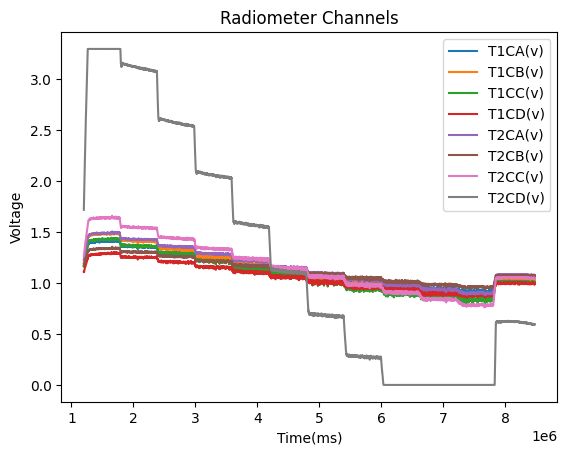

In [64]:
from os import walk
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display
from scipy.optimize import curve_fit

if __name__ == '__main__':
     sensor_file = 'Data/radiometer1_25_5-55_061523_sensor.csv'
     bb_file = 'Data/radiometer1_30_5-55_061623_BB.txt'

     bb_df = pd.read_csv(bb_file)
     bb_df.to_csv(r'Data/radiometer1_30_5-55_061623_BB.csv', index = None)
     
     bb_df.columns = ['BB Temp']
     
     display(bb_df)
     data = pd.read_csv(sensor_file)
     channel_col = []
     internal_col = []
     nums = [1,2]
     channels = ['A', 'B', 'C', 'D']
     for num in nums:
          for chan in channels:
               channel_col.append("T" + str(num) + "C" + str(chan) + "(v)")
          internal_col.append("T" + str(num) +"Therm(c)")

     data[data["Time(ms)"] > 1200000].plot(x = "Time(ms)", y = channel_col)
     #plt.scatter(bb_index, bb_df['BB Temp'])
     plt.title("Radiometer Channels")
     plt.ylabel("Voltage")
     plt.show()


Segment the data into different BB temps

In [65]:
#segment the data into the different BB temps
temp_dict = {}
temp_ranges = np.arange(55, 0, -5)
time_interval = 10 #minute length of each trial
lower_bound = 1200000 #time after s
time_interval_ms = 60000 * time_interval #convert minutes to milliseconds
for i in range(0, temp_ranges.size):
    temp_dict[str(temp_ranges[i])] = data[(data["Time(ms)"] > (lower_bound+120000)) & (data["Time(ms)"] < (lower_bound + time_interval_ms-30000))]
    lower_bound += time_interval_ms

Plot the sensor readings at different blackbody temperatures

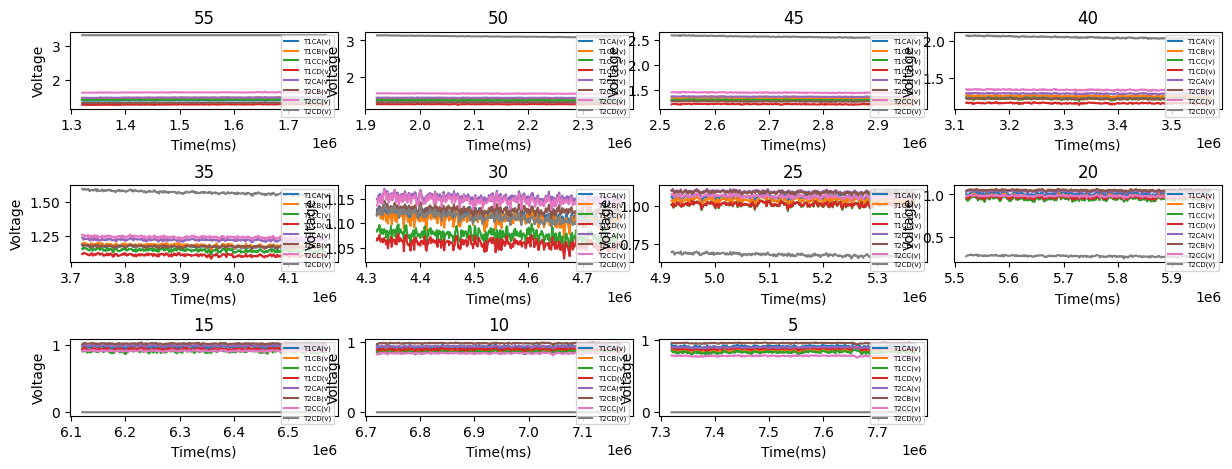

In [92]:
temp_max_min = pd.DataFrame()
temp_plots = plt.figure().tight_layout()
i = 1

for key in temp_dict:
    ax = plt.subplot(3, 4, i)
    plt.subplots_adjust(left=0.1, right=1.9, bottom=0.1, top=0.9, wspace=0.1, hspace=1)

    plt.plot(temp_dict[key].loc[:,"Time(ms)"], temp_dict[key].loc[:,channel_col])
    plt.title(key)
    plt.ylabel("Voltage")
    plt.xlabel("Time(ms)")
    plt.legend(channel_col, fontsize = 5)
    i += 1
    max_temp = temp_dict[key].max() 
    max_temp_df = pd.DataFrame({'Max at ' + str(key): max_temp}).T

    min_temp = temp_dict[key].min() 
    min_temp_df = pd.DataFrame({'Min at ' + str(key): min_temp}).T
    temp_max_min= pd.concat([temp_max_min, max_temp_df, min_temp_df]) #transpose

plt.show()

In [67]:
#create histograms for each channel
""" for key in temp_dict:
    plt.figure()
    temp = temp_dict[key]
    i = 1
    for chan in channel_col:
        plt.subplot(2, 4, i)
        plt.hist(temp[chan], bins=30, density=True, alpha=0.6, color='g')
        plt.title(chan)
        i += 1 """

" for key in temp_dict:\n    plt.figure()\n    temp = temp_dict[key]\n    i = 1\n    for chan in channel_col:\n        plt.subplot(2, 4, i)\n        plt.hist(temp[chan], bins=30, density=True, alpha=0.6, color='g')\n        plt.title(chan)\n        i += 1 "

,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
55,55,1.409046,1.483071,1.429318,1.288478,1.490243,1.337893,1.639658,3.299171
50,50,1.355768,1.412965,1.364406,1.253866,1.429239,1.304602,1.544424,3.107465
45,45,1.292738,1.332296,1.288474,1.205961,1.357955,1.260969,1.439367,2.567823
40,40,1.230165,1.253006,1.213395,1.155359,1.286394,1.215012,1.336583,2.054112
35,35,1.171825,1.178730,1.142710,1.106393,1.218403,1.170563,1.239627,1.569505
30,30,1.116624,1.108862,1.076000,1.059048,1.152526,1.126421,1.146313,1.111416
25,25,1.060357,1.038284,1.009275,1.010313,1.092242,1.086543,1.061068,0.681435
20,20,1.009474,0.974190,0.948627,0.965852,1.036819,1.050134,0.982274,0.276765
15,15,0.969487,0.923349,0.900225,0.930634,0.984814,1.015159,0.908358,0.000380
10,10,0.935323,0.879811,0.858751,0.900100,0.938867,0.984891,0.841557,0.000372


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
55,55,0.004886,0.005469,0.005748,0.006076,0.004465,0.004362,0.004625,0.000001
50,50,0.004377,0.005361,0.005153,0.003721,0.003409,0.003001,0.005012,0.017633
45,45,0.006300,0.007384,0.007210,0.005668,0.004848,0.004242,0.006190,0.016651
40,40,0.006730,0.007830,0.007564,0.006302,0.005220,0.004841,0.006108,0.013660
35,35,0.007896,0.009165,0.008981,0.007597,0.006243,0.006224,0.007320,0.012434
30,30,0.008415,0.009755,0.009481,0.008061,0.006312,0.006219,0.007235,0.009970
25,25,0.011206,0.013008,0.012405,0.010541,0.007167,0.007074,0.007891,0.009075
20,20,0.014115,0.016172,0.015478,0.013266,0.007112,0.007100,0.007656,0.007803
15,15,0.013938,0.016030,0.015232,0.012995,0.006211,0.006254,0.006709,0.000001
10,10,0.011572,0.013369,0.012770,0.010699,0.005447,0.005420,0.005797,0.000001


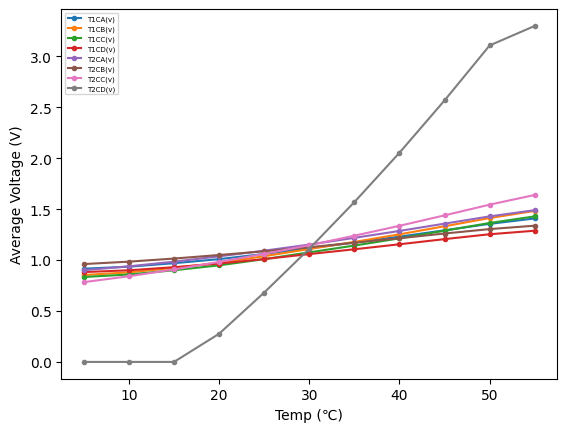

In [68]:
#calculate averages
ch_avgs = pd.DataFrame()
ch_std_dev = pd.DataFrame()
for key in temp_dict:
    temps = temp_dict[key]
    ch_avgs[key] = temps[channel_col].mean()
    ch_std_dev[key] = temps[channel_col].std()
ch_avgs=ch_avgs.T
ch_avgs.insert(loc = 0,
          column = 'Temp',
          value = temp_ranges)
ch_std_dev =ch_std_dev.T
ch_std_dev.insert(loc = 0,
          column = 'Temp',
          value = temp_ranges)

plt.plot(ch_avgs.loc[:,"Temp"], ch_avgs.loc[:,channel_col], marker = '.')
plt.legend(channel_col, fontsize = 5)
plt.xlabel("Temp (\N{DEGREE CELSIUS})")
plt.ylabel("Average Voltage (V)")
display(ch_avgs)
display(ch_std_dev)

In [69]:
#PLanck Radiance
def planck_radiance(wavelength, temperature):
    h = 6.62607015e-34  # Planck's constant
    c = 299792458  # Speed of light
    k = 1.38064852e-23  # Boltzmann constant

    #convert celsius to Kelvin
    temperature += 273.15
    
    numerator = 2 * h * c ** 2
    denominator = wavelength ** 5 * (np.exp((h * c) / (wavelength * k * temperature)) - 1)
    radiance = numerator / denominator
    return radiance

def linear_fit(x, slope , b):
    return slope * x + b

def quadratic_fit(x, a, b, c):
    return a * (x ** 2) + b * x + c

def gaussian_fit(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

,Time(ms),T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
1062,1200357,35.701904,35.891124,35.977166,37.166582,36.745999,37.491865,35.791987,36.471707
1063,1201486,34.750026,35.154324,35.875477,37.155410,36.648533,37.264266,35.540732,35.798849
1064,1202615,34.276792,34.450190,34.662153,35.966743,35.995334,37.014722,34.765750,34.983842
1065,1203744,34.671953,34.552065,34.835827,36.107052,35.331038,36.019720,33.976159,34.248544
1066,1204873,33.677545,33.724709,34.259495,35.666825,34.397595,34.826227,33.262787,33.486460
...,...,...,...,...,...,...,...,...,...
7431,8394657,18.152386,17.537973,17.567237,22.496910,15.070912,17.941743,13.631663,22.019657
7432,8395786,15.445428,13.990939,14.981050,19.331920,15.521835,18.839234,13.633273,22.140564
7433,8396915,12.331079,12.111995,12.406691,16.081046,16.047079,18.552571,14.198069,22.270554
7434,8398044,14.303685,12.977916,13.501913,17.730897,15.881843,18.211254,13.599521,22.111128


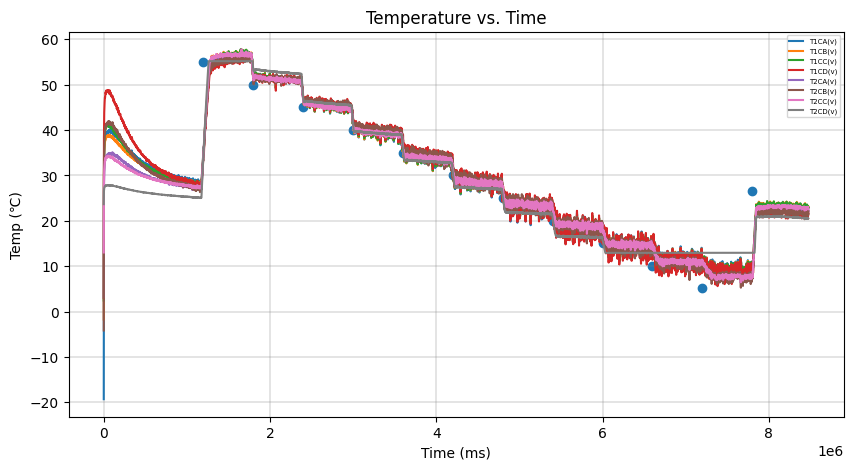

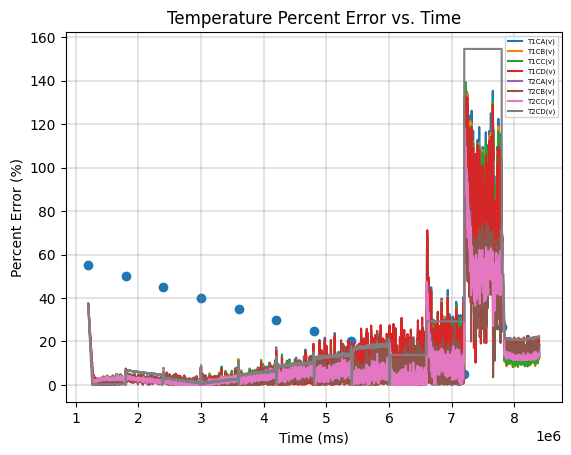

In [70]:
#obtain curves for data
temp_popt = {}
temp_pcov = {}

fig, ax = plt.subplots(figsize = (10, 5))
bb_index = np.arange(1.2e6,8.4e6,0.6e6)
data_temp = data.copy()
temp_error = pd.DataFrame()
for chan in channel_col:
    temp_popt[chan], temp_pcov[chan] = curve_fit(linear_fit, ch_avgs[chan], ch_avgs["Temp"])
    calc_temp = linear_fit(data[chan], *temp_popt[chan])
    data_temp[chan] = calc_temp
    plt.plot(data["Time(ms)"], calc_temp)
    plt.xlabel("Time (ms)")
    plt.ylabel("Temp (\N{DEGREE CELSIUS})")

plt.title("Temperature vs. Time")
plt.grid(color='gray', linestyle='-', linewidth=0.3)
plt.legend(channel_col, fontsize = 5)
plt.scatter(bb_index, bb_df['BB Temp'])
#display(data_temp)
#Plot error
plt.figure()
lower_bound = 1200000
#display(data_temp)
for i in range(0, bb_df['BB Temp'].size):
    bb_temp = bb_df['BB Temp']
    data_temp_interval = data_temp[(data_temp["Time(ms)"] > (lower_bound)) & (data_temp["Time(ms)"] < (lower_bound + time_interval_ms))]
    #display(data_temp_interval)
    temp_error = pd.concat([temp_error, ((abs((data_temp_interval[channel_col] - bb_temp[i])/bb_temp[i])) * 100)]) #convert the voltage to a temp and calculate percent error
    lower_bound += time_interval_ms
temp_times = data_temp[(data_temp["Time(ms)"] > (1200000)) & (data_temp["Time(ms)"] < (lower_bound))]["Time(ms)"]
temp_error.insert(loc = 0,column = 'Time(ms)', value = temp_times)

for ch in channel_col:
    plt.plot(temp_error["Time(ms)"], temp_error[ch])

plt.xlabel("Time (ms)")
plt.ylabel("Percent Error (%)")
plt.title("Temperature Percent Error vs. Time")
plt.grid(color='gray', linestyle='-', linewidth=0.3)
plt.legend(channel_col, fontsize = 5)
plt.scatter(bb_index, bb_df['BB Temp'])
display(temp_error)
#plt.plot(data["Time(ms)"], linear_fit(data["T2CD(v)"], *temp_popt["T2CD(v)"]))
#plt.plot(data["T1CB(v)"], linear_fit(data["T1CB(v)"], *temp_popt["T1CB(v)"]))

#line up BB temp and measured temp, find error

,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
55,55,56.401557,56.553230,56.452115,55.213557,56.152923,55.395256,56.517571,55.175539
50,50,51.300235,51.269933,51.287808,51.238386,51.145188,51.174741,51.085012,52.720206
45,45,45.265109,45.190621,45.246759,45.736545,45.293569,45.643120,45.092100,45.808582
40,40,39.273824,39.215209,39.273610,39.924963,39.419260,39.816974,39.228888,39.229084
35,35,33.687866,33.617681,33.650081,34.301206,33.837931,34.181849,33.698069,33.022337
30,30,28.402359,28.352271,28.342703,28.863652,28.430224,28.585792,28.375040,27.155228
25,25,23.014849,23.033423,23.034170,23.266524,23.481590,23.530260,23.512308,21.648120
20,20,18.142863,18.203169,18.209101,18.160145,18.931959,18.914408,19.017516,16.465182
15,15,14.314125,14.371733,14.358373,14.115429,14.663003,14.480483,14.801069,12.925306
10,10,11.043021,11.090685,11.058710,10.608561,10.891274,10.643266,10.990429,12.925205


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
55,55,0.467875,0.412185,0.457269,0.697868,0.366555,0.552991,0.263822,0.000019
50,50,0.419059,0.404007,0.409944,0.427359,0.279840,0.380514,0.285931,0.225841
45,45,0.603207,0.556471,0.573578,0.651015,0.397997,0.537765,0.353092,0.213262
40,40,0.644430,0.590063,0.601792,0.723741,0.428536,0.613690,0.348416,0.174954
35,35,0.756015,0.690651,0.714501,0.872490,0.512515,0.789037,0.417588,0.159251
30,30,0.805702,0.735184,0.754253,0.925806,0.518144,0.788406,0.412732,0.127693
25,25,1.073002,0.980285,0.986887,1.210605,0.588347,0.896859,0.450129,0.116237
20,20,1.351491,1.218754,1.231442,1.523586,0.583798,0.900057,0.436706,0.099936
15,15,1.334547,1.208062,1.211864,1.492465,0.509827,0.792850,0.382729,0.000017
10,10,1.107978,1.007487,1.015970,1.228797,0.447171,0.687081,0.330696,0.000014


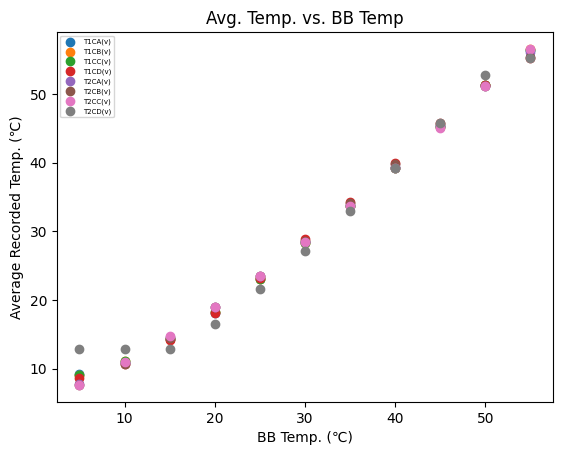

In [71]:
#calculate noise in temperature domain
conv_temp_dict = {}
plt.figure()

conv_ch_avgs = pd.DataFrame()
conv_ch_std_dev = pd.DataFrame()
lower_bound = 1200000
#for each segmented temp data, convert voltage to temps and calculate mean/standard deviation
for i in range(0, temp_ranges.size):
    conv_temp_dict[str(temp_ranges[i])] = data_temp[(data_temp["Time(ms)"] > (lower_bound+120000)) & (data_temp["Time(ms)"] < (lower_bound + time_interval_ms-30000))]
    lower_bound += time_interval_ms

#for each BB temp, find the average and standard deviation of the recorded temperature
for temp in conv_temp_dict: 
    temp_segment = conv_temp_dict[temp]
    conv_ch_avgs[temp] = temp_segment[channel_col].mean()
    conv_ch_std_dev[temp] = temp_segment[channel_col].std()

#add converted temp averages and std deviations to the dataframe and plot them
conv_ch_avgs=conv_ch_avgs.T
conv_ch_avgs.insert(loc = 0, column = 'Temp', value = temp_ranges)
conv_ch_std_dev =conv_ch_std_dev.T
conv_ch_std_dev.insert(loc = 0, column = 'Temp', value = temp_ranges)
display(conv_ch_avgs)
display(conv_ch_std_dev)
for ch in channel_col:
    plt.scatter(temp_ranges, conv_ch_avgs[ch])
plt.xlabel("BB Temp. (\N{DEGREE CELSIUS})")
plt.ylabel("Average Recorded Temp. (\N{DEGREE CELSIUS})")
plt.title("Avg. Temp. vs. BB Temp")
plt.legend(channel_col, fontsize = 5)

Calculating Temperature to Radiance Curves

,Wavelength,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
0,0.000008,0.000187,0.000133,0.002295,0.000338,1.404026e-07,4.454326e-07,0.000000e+00,0.000238
1,0.000008,-0.000067,-0.000430,0.001002,-0.000545,8.424158e-08,4.136160e-07,0.000000e+00,0.000238
2,0.000008,0.000286,-0.000307,-0.000578,-0.000681,1.123221e-07,6.363323e-08,0.000000e+00,0.000238
3,0.000008,0.001145,0.000409,-0.000880,-0.000311,8.424158e-08,-2.227163e-07,0.000000e+00,0.000238
4,0.000008,0.001702,0.000956,0.000748,-0.000220,-1.684832e-07,-2.863495e-07,0.000000e+00,0.000238
...,...,...,...,...,...,...,...,...,...
522,0.000014,0.000311,0.002002,0.002871,-0.003243,3.436972e-03,1.652109e-03,1.935983e-109,0.883726
523,0.000014,-0.002504,0.003802,-0.003127,-0.003970,1.564787e-03,1.181987e-03,2.387713e-112,0.714796
524,0.000014,-0.002829,0.007300,-0.003019,0.001566,1.566472e-03,2.011542e-03,2.645844e-115,0.476531
525,0.000014,-0.000525,0.009125,0.002786,0.007141,5.124022e-03,4.265462e-03,2.632938e-118,0.238265


,Temperature,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
0,55,1.547446e+07,1.552832e+07,1.554139e+07,1.551138e+07,1.443362e+07,1.355954e+07,1.228401e+07,1.372817e+07
1,50,1.427700e+07,1.435758e+07,1.438828e+07,1.438650e+07,1.352568e+07,1.275633e+07,1.160810e+07,1.287503e+07
2,45,1.313945e+07,1.324303e+07,1.328910e+07,1.331230e+07,1.264985e+07,1.197862e+07,1.095088e+07,1.205205e+07
3,40,1.206100e+07,1.218406e+07,1.224334e+07,1.228843e+07,1.180627e+07,1.122664e+07,1.031260e+07,1.125931e+07
4,35,1.104079e+07,1.117999e+07,1.125042e+07,1.131443e+07,1.099503e+07,1.050058e+07,9.693500e+06,1.049686e+07
5,30,1.007786e+07,1.023005e+07,1.030968e+07,1.038979e+07,1.021620e+07,9.800609e+06,9.093804e+06,9.764733e+06
6,25,9.171170e+06,9.333401e+06,9.420404e+06,9.513928e+06,9.469800e+06,9.126871e+06,8.513730e+06,9.062912e+06
7,20,8.319591e+06,8.489111e+06,8.581766e+06,8.686183e+06,8.755822e+06,8.479487e+06,7.953482e+06,8.391350e+06
8,15,7.521906e+06,7.696169e+06,7.792878e+06,7.905818e+06,8.074207e+06,7.858545e+06,7.413244e+06,7.749958e+06
9,10,6.776811e+06,6.953477e+06,7.052762e+06,7.172019e+06,7.424852e+06,7.264101e+06,6.893184e+06,7.138610e+06


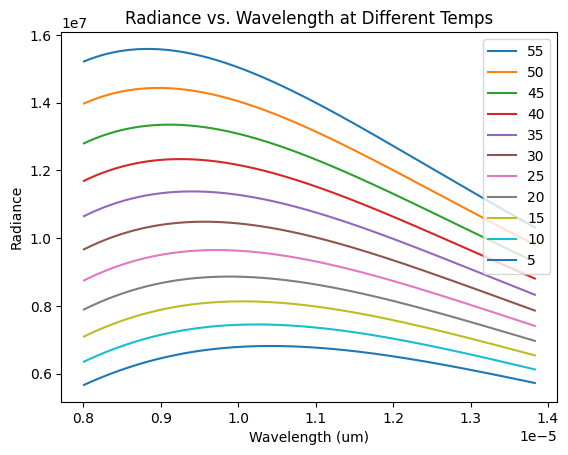

In [72]:
#units are watt/meter squared,

#read in response curve
dex = pd.read_csv("Data/dexter_filters.csv")
dex["Wavelength"] = dex["Wavelength"] * 1e-6
#normalize each channel by dividing by the max
dex_norm = dex
#chans = ['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']
for ch in channel_col:
    dex_norm[ch] = dex[ch] / dex[ch].abs().max()

display(dex_norm)


#use Planck radiance equation to obtain curves
planck = pd.DataFrame()
planck["Wavelength"] = dex_norm["Wavelength"]
plt.figure()
for temp in temp_ranges:
    planck[temp] = planck_radiance((planck["Wavelength"]), temp)
    plt.plot(planck["Wavelength"], planck[temp])
    plt.legend(temp_ranges)
    plt.title("Radiance vs. Wavelength at Different Temps")
    plt.xlabel("Wavelength (um)")
    plt.ylabel("Radiance")

be_radiance = pd.DataFrame()
be_radiance["Temperature"] = temp_ranges

#calculate BE radiance for each temperature at each channel
for ch in channel_col:
    radiance = []
    for temp in temp_ranges:
        numerator = 0
        for a, b in zip(planck[temp], dex_norm[ch]):
            numerator += a * b
        
        denominator = dex_norm[ch].sum()
        radiance.append(numerator/denominator)
    be_radiance[ch] = radiance

display(be_radiance)



Plot radiance vs. time from data

,Time(ms),T1CA(v),T1CB(v),T1CC(v),T1CD(v),T1Therm(c),T2CA(v),T2CB(v),T2CC(v),T2CD(v),T2Therm(c)
0,787,-1929.428965,-187.657156,135.219129,249.569331,24.328737,192.728908,-644.049877,705.205797,315.967667,24.284843
1,1916,1945.468779,1835.137428,2103.646278,3513.903924,24.339134,1735.229349,2749.488105,1376.729251,345.066398,24.295159
2,3045,2624.259816,2229.139713,2531.623709,4290.790224,24.344069,2102.441491,3589.917153,1558.394414,352.765731,24.299110
3,4174,2955.991483,2420.962019,2734.282977,4642.425426,24.346699,2295.546927,4029.089987,1661.363122,357.466732,24.301617
4,5303,3104.383501,2517.653999,2839.300322,4821.200634,24.349596,2405.894855,4292.298991,1719.057977,360.407309,24.304330
...,...,...,...,...,...,...,...,...,...,...,...
7497,8469202,2015.006859,1596.108638,1681.517840,2250.594013,31.763208,1756.417765,2603.891707,1261.028484,275.838480,31.734395
7498,8470331,2038.197128,1643.243675,1726.053615,2381.568563,31.763882,1800.928552,2720.075351,1280.182851,276.553491,31.736077
7499,8471460,2125.980775,1702.090457,1785.402199,2470.221992,31.764724,1788.888290,2695.031613,1278.193580,276.417328,31.737212
7500,8472589,2102.328994,1661.512807,1751.919492,2403.460859,31.766365,1738.492547,2574.238837,1246.625889,275.066295,31.738347


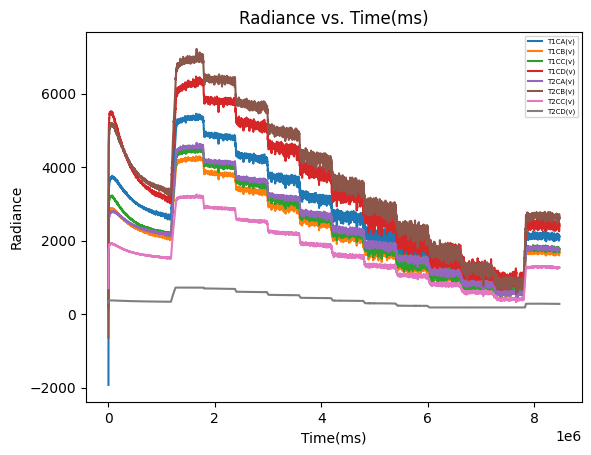

In [73]:
data_radiance = pd.DataFrame()
data_radiance = data.copy()
radiance_popt = {}
radiance_pcov = {}
plt.figure()
for chan in channel_col:
    #determine line of best fit for temperature to radiance function using lookup table, then convert temps using that line
    radiance_popt[chan], radiance_pcov[chan] = curve_fit(linear_fit, be_radiance["Temperature"], be_radiance[chan])
    temp_to_radiance = linear_fit(data_temp[chan], *temp_popt[chan] )
    data_radiance[chan] = temp_to_radiance
    plt.plot(data_temp["Time(ms)"], data_radiance[chan])
    plt.xlabel("Time(ms)")
    plt.ylabel("Radiance")
    plt.legend(channel_col, fontsize = 5)
plt.title("Radiance vs. Time(ms)")
display(data_radiance)

,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
55,55,5321.884904,4206.723878,4433.974646,6248.469438,4543.331333,6908.542163,3186.992998,719.597311
50,50,4833.437972,3808.566635,4023.110962,5791.924025,4132.253783,6373.484434,2877.096158,688.149923
45,45,4255.580074,3350.420468,3542.495123,5160.041610,3651.903053,5672.210685,2535.234283,599.627269
40,40,3681.919917,2900.104365,3067.281249,4492.585592,3169.689728,4933.598356,2200.771143,515.358425
35,35,3147.069504,2478.266181,2619.882649,3846.701272,2711.526714,4219.202714,1885.269081,435.863687
30,30,2640.986955,2081.456905,2197.636422,3222.202110,2267.616045,3509.760086,1581.620313,360.718979
25,25,2125.137759,1680.620424,1775.298330,2579.376025,1861.389963,2868.842703,1304.228909,290.185074
20,20,1658.649412,1316.605214,1391.423853,1992.912195,1487.917483,2283.665936,1047.826342,223.803081
15,15,1292.051264,1027.862323,1085.066324,1528.379446,1137.485276,1721.553051,807.301869,178.465078
10,10,978.845957,780.597607,822.550580,1125.618276,827.869601,1235.088120,589.926351,178.463793


,Temp,T1CA(v),T1CB(v),T1CC(v),T1CD(v),T2CA(v),T2CB(v),T2CC(v),T2CD(v)
55,55,44.798657,31.062880,36.379586,80.149647,30.089940,70.105688,15.049534,0.000243
50,50,40.124554,30.446599,32.614482,49.081851,22.971667,48.239848,16.310739,2.892519
45,45,57.756490,41.936518,45.632946,74.768593,32.670975,68.175422,20.141932,2.731422
40,40,61.703629,44.468071,47.877553,83.121157,35.177879,77.800779,19.875157,2.240781
35,35,72.387733,52.048477,56.844488,100.204785,42.071556,100.030560,23.821067,2.039652
30,30,77.145222,55.404579,60.007128,106.328132,42.533641,99.950475,23.544038,1.635470
25,25,102.738961,73.875767,78.515074,139.037081,48.296506,113.699742,25.677331,1.488741
20,20,129.404032,91.847171,97.971488,174.982687,47.923117,114.105122,24.911642,1.279957
15,15,127.781656,91.041371,96.413869,171.408567,41.850977,100.513886,21.832551,0.000213
10,10,106.087889,75.925736,80.828904,141.126389,36.707588,87.105036,18.864328,0.000177


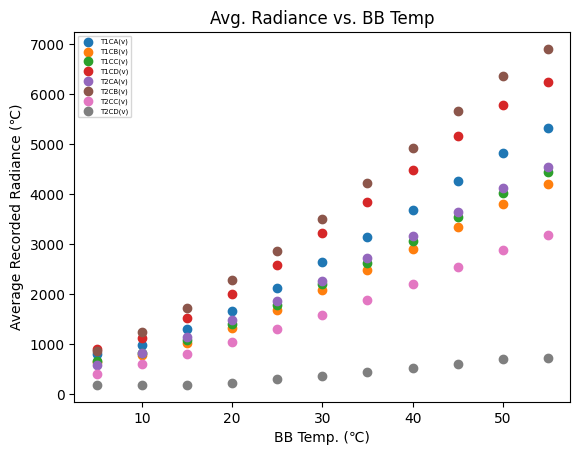

In [74]:
#calculate radiance in temperature domain
rad_dict = {}
plt.figure()

rad_ch_avgs = pd.DataFrame()
rad_ch_std_dev = pd.DataFrame()
lower_bound = 1200000
#for each segmented temp data, convert voltage to temps and calculate mean/standard deviation
for i in range(0, temp_ranges.size):
    rad_dict[str(temp_ranges[i])] = data_radiance[(data_radiance["Time(ms)"] > (lower_bound+120000)) & (data_radiance["Time(ms)"] < (lower_bound + time_interval_ms-30000))]
    lower_bound += time_interval_ms

#for each BB temp, find the average and standard deviation of the recorded temperature
for rad in rad_dict: 
    rad_segment = rad_dict[rad]
    rad_ch_avgs[rad] = rad_segment[channel_col].mean()
    rad_ch_std_dev[rad] = rad_segment[channel_col].std()
  
rad_ch_avgs=rad_ch_avgs.T
rad_ch_avgs.insert(loc = 0, column = 'Temp', value = temp_ranges)
rad_ch_std_dev =rad_ch_std_dev.T
rad_ch_std_dev.insert(loc = 0, column = 'Temp', value = temp_ranges)
display(rad_ch_avgs)
display(rad_ch_std_dev)
for ch in channel_col:
    plt.scatter(temp_ranges, rad_ch_avgs[ch])
plt.xlabel("BB Temp. (\N{DEGREE CELSIUS})")
plt.ylabel("Average Recorded Radiance (\N{DEGREE CELSIUS})")
plt.title("Avg. Radiance vs. BB Temp")
plt.legend(channel_col, fontsize = 5)